<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ContrastAndColor/TP_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to image processing - Color in images

## Introduction

In this practical session perceived color spaces as well as different classical color spaces are explored. Techniques are studied to visualize the distribution of colors.
In addition, different algorithms are tested for white balance correction in images. Finally, a demosicing algorithm for the reconstruction of color images is studied.

For some parts of the session (cells with commands written as `todo_something`...), you are supposed to code by yourself.

**Authors:**
* [Julie Delon](https://github.com/judelo)
* Lucía Bouza

## Importing packages

Below is a list of packages required in the notebook:

- `numpy`
- `matplotlib` (display of images and graphics)
-  `os` (interactions with the operating system)
- `scs` (convolutions computation)
- `KMeans` (KMeans algorithm)



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy.signal as scs
from sklearn.cluster import KMeans

To import the solutions, execute the following cell. If you are using a Windows system, comment the `os.system` line, download the file by hand, and place it in the same folder as the notebook.

In [9]:
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ContrastAndColor/Solutions/TP_color.py")
from TP_color import *

## Load and display images

A color image is made of three channels: red, green and blue. A color image in $\mathbb{R}^{N\times M}$ is stored as a $N\times M\times 3$ matrix.

    
**Be careful with the functions `plt.imread()` and `plt.imshow()` of `matplotlib`.** 
- `plt.imread()` reads png images as numpy arrays of floating points between 0 and 1, but it reads jpg or bmp images as numpy arrays of 8 bit integers. 

- In this practical session, we assume images are encoded as floating point values between 0 and 1, so if you load a jpg or bmp file you must convert the image to float type and normalize its values to $[0,1]$.

- If 'im' is an image encoded as a float numpy array, `plt.imshow(im)` will display all values above 1 in white and all values below 0 in black. If the 'im' image is 8-bit encoded, `plt.imshow(im)` will display 0 in black and 255 in white.

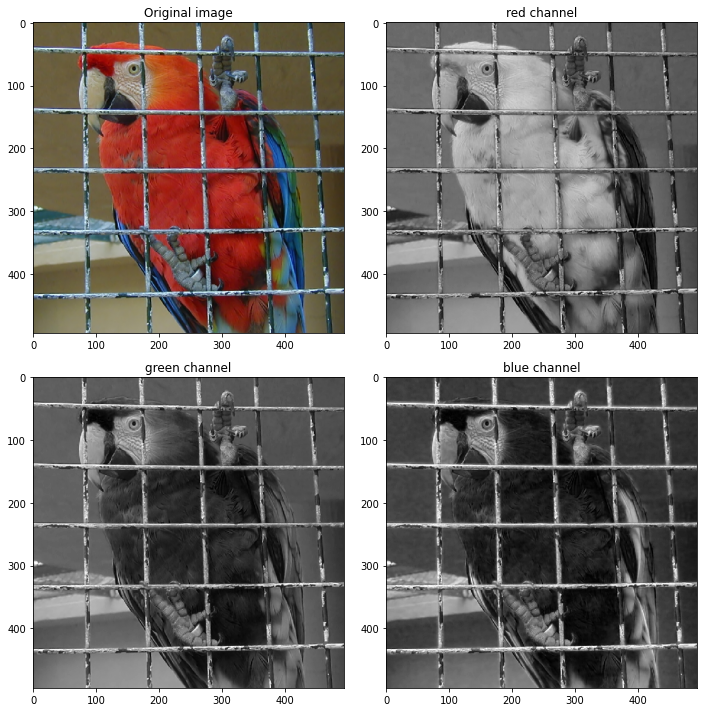

In [10]:
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/parrot.png")
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/parrotcompressed.png")

imrgb = plt.imread("parrot.png")

# extract the three (red,green,blue) channels from imrgb
imred   = imrgb[:,:,0]
imgreen = imrgb[:,:,1]
imblue  = imrgb[:,:,2]

#image size 
[nrow,ncol,nch]=imrgb.shape
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

#we display the images
axes[0,0].imshow(imrgb)
axes[0,0].set_title('Original image')
axes[0,1].imshow(imred, cmap="gray")
axes[0,1].set_title('red channel')
axes[1,0].imshow(imgreen, cmap="gray")
axes[1,0].set_title('green channel')
axes[1,1].imshow(imblue, cmap="gray")
axes[1,1].set_title('blue channel')
fig.tight_layout()

It might be useful to convert the color image to gray level. This can be done by averaging the three channels, or by computing another well chosen linear combination of the coordinates R, G and B. 

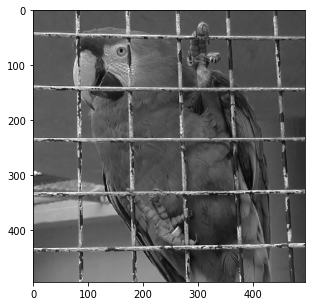

In [11]:
imgray = np.sum(imrgb,2)/3
plt.figure(figsize=(5, 5))
plt.imshow(imgray,cmap='gray')

## Color spaces

### Opponent spaces
Color opponent spaces are characterized by a channel representing an
achromatic signal, as well as two channels encoding color
opponency. The two chromatic channels generally represent an
approximate red-green opponency and yellow- blue opponency. 
$$ O_1 = \frac 1 {\sqrt{2}} (R-G),\;  O_2 =  \frac 1 {\sqrt{6}}
(R+G-2B),\; O_3 = \frac 1 {\sqrt{3}} (R+G+B)$$

- Display the O_1, O_2 and O_3 coordinates for different color images.

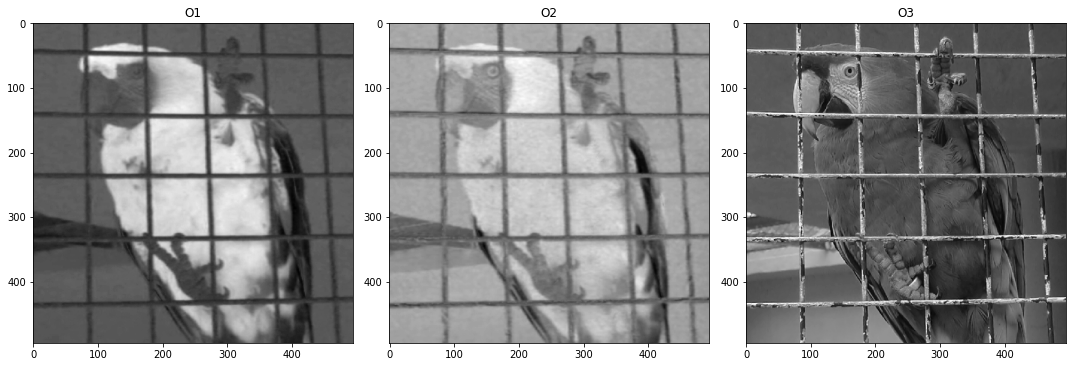

In [12]:
O1 = (imred-imgreen)/np.sqrt(2)
O2 = (imred+imgreen-2*imblue)/np.sqrt(6)
O3 = (imred+imgreen+imblue)/np.sqrt(3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

axes[0].imshow(O1, cmap='gray')
axes[0].set_title('O1')
axes[1].imshow(O2, cmap='gray')
axes[1].set_title('O2')
axes[2].imshow(O3, cmap='gray')
axes[2].set_title('O3')
fig.tight_layout()

### HSV/HSL/HSI spaces (Hue, Saturation, Value/Luminance/Intensity)
These color spaces are obtained by a non-linear transformation of the
RGB coordinates into polar coordinates. The luminance (or value V)
corresponds to the vertical axis of the cylinder; the hue corresponds to the
angular coordinate and the saturation to the distance from the axis.
See https://en.wikipedia.org/wiki/HSL_and_HSV for more details.


The conversion from RGB to HSI boils down to 
$$ H=atan\left(\frac{O_1}{O_2}\right),\;S=\sqrt{O_1^2+O_2^2},\; I=0_3$$

 - Display the H, S and I coordinates coordinates for a given color image.

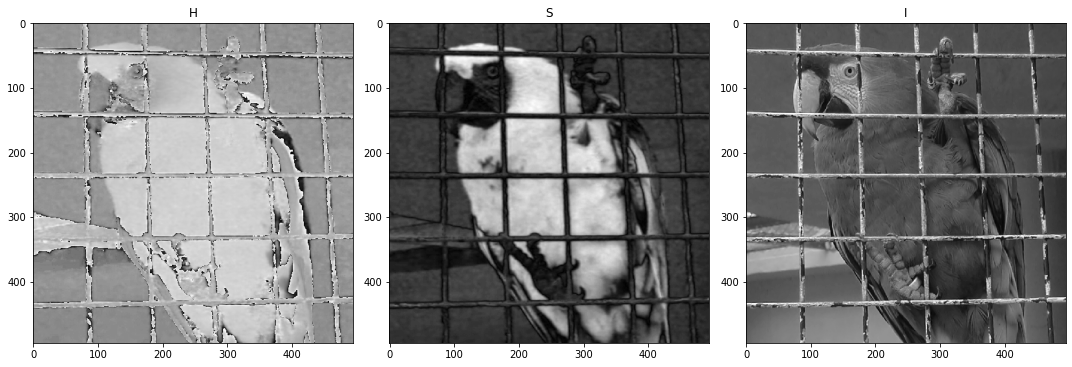

In [13]:
H=np.arctan(O1/(O2+0.001))
S=np.sqrt(O1**2+O2**2)
I=O3

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

axes[0].imshow(H, cmap='gray')
axes[0].set_title('H')
axes[1].imshow(S, cmap='gray')
axes[1].set_title('S')
axes[2].imshow(I, cmap='gray')
axes[2].set_title('I')
fig.tight_layout()

 - Observe the effect of JPG compression on the H,S,I channels by applying the conversion on the images `parrot` and `parrotcompressed`.

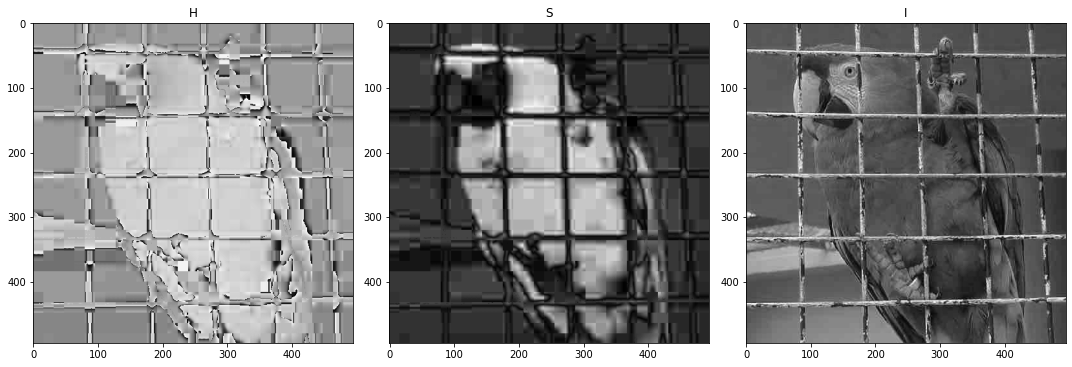

In [14]:
parrotcompressed = plt.imread("parrotcompressed.png")
todo_HSI_after_compression(parrotcompressed)

The conversion from RGB to HSV is a little bit more complex, you can use the function colors.rgb_to_hsv de matplotlib.

In [15]:
imhsv = matplotlib.colors.rgb_to_hsv(imrgb)

 - Display the H, S and V coordinates for the same image

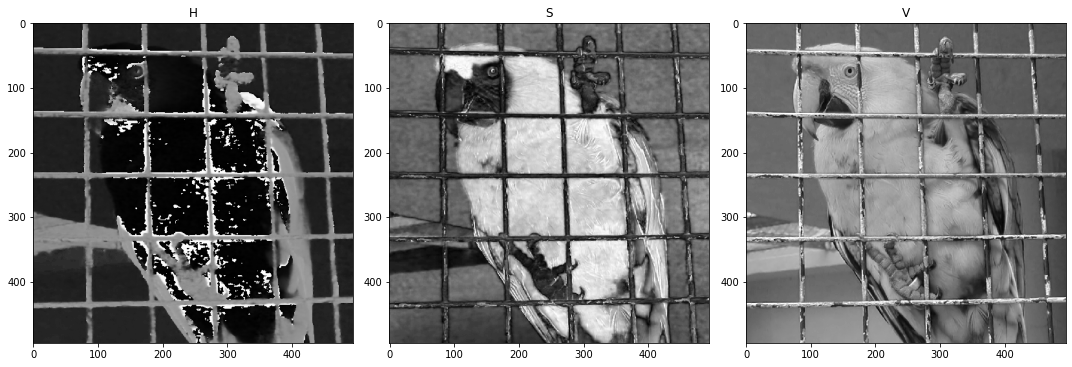

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

axes[0].imshow(imhsv[:,:,0], cmap='gray')
axes[0].set_title('H')
axes[1].imshow(imhsv[:,:,1], cmap='gray')
axes[1].set_title('S')
axes[2].imshow(imhsv[:,:,2], cmap='gray')
axes[2].set_title('V')
fig.tight_layout()

 - Reconstruct and display the RGB image after the following
      transformations :
      + saturation reduction
      + rotation of the hue channel
      + gamma transformation on the luminance ($x\mapsto x^\gamma$
        with $\gamma <1$).

## Space of perceived colors

Simulation of the set of monochromatic colors in RGB. The cone responses are approximated by Gaussian distributions.

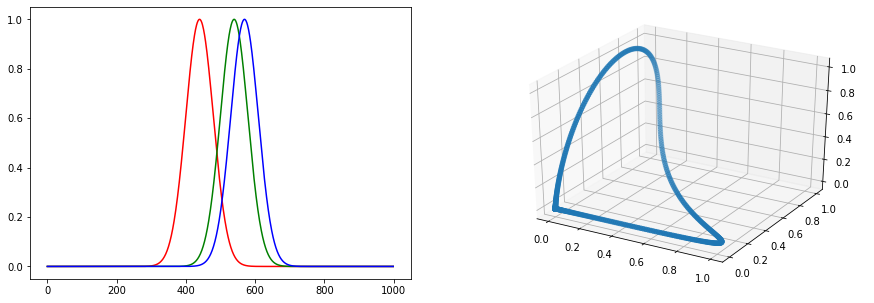

In [17]:
x=np.linspace(0,1000,1000)
r=np.exp(-(x-440)**2/(2*40**2))
g=np.exp(-(x-540)**2/(2*40**2))
b=np.exp(-(x-570)**2/(2*40**2))

fig = plt.figure(figsize=(15, 5))
axis = fig.add_subplot(1, 2, 1)
axis.plot(r,'r')
axis.plot(g,'g')
axis.plot(b,'b')

axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(r,g,b)

- Maxwell triangle : display the same curve projected on the plane $r+g+b=1$.

## Color distributions and color quantization

We will now display the color distribution of an RGB image as a 3D point cloud. If the image is large, the point cloud will be too dense for vizualization. A solution is to subsample randomly this point cloud for vizualization. 

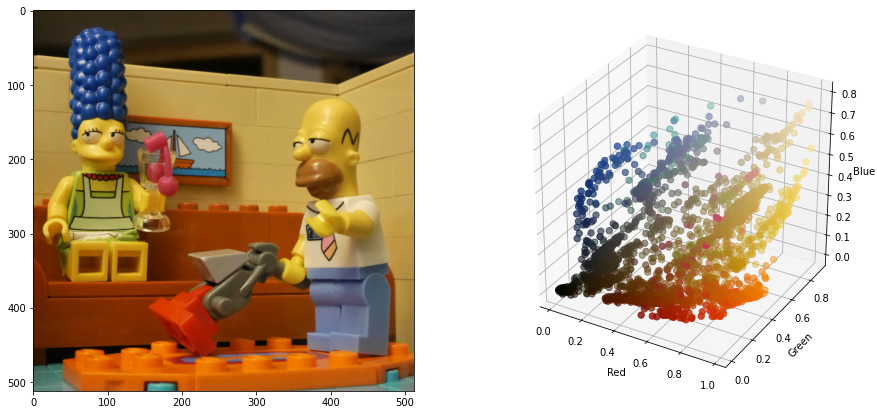

In [18]:
os.system("wget -c https://raw.githubusercontent.com/judelo/notebooks/master/im/simpson512.png")
imrgb = plt.imread("simpson512.png")

fig = plt.figure(figsize=(15, 7))
axis = fig.add_subplot(1, 2, 1)
axis.imshow(imrgb)
[nrow,ncol,nch]=imrgb.shape
X = imrgb.reshape((nrow*ncol,3))
nb = 3000
idx = np.random.randint(X.shape[0], size=(nb,))
Xs = X[idx, :]


axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=Xs,s=40)
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

Another solution is to perform clustering on the point cloud before displaying it, for instance with the Kmeans algorithm (which boils down to Lloyd-Max quantization for gray-level images). The 'scatter' command of matplotlib permits to display the point cloud with colors based on the weights of the points. We will need the scikitlearn package for 'kmeans'.

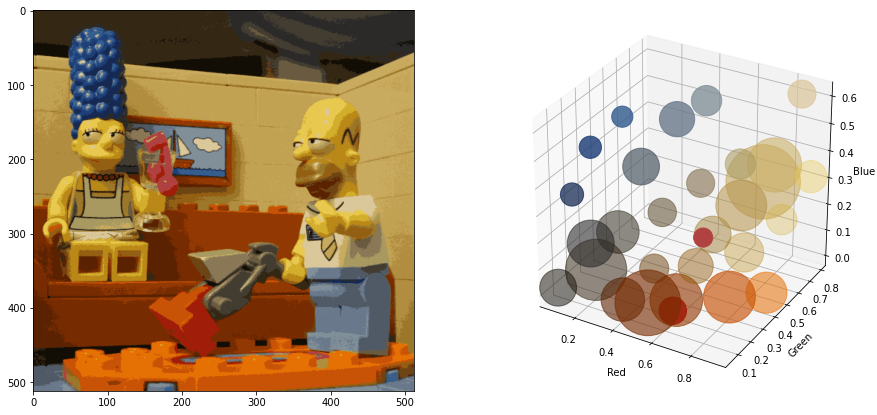

In [19]:
k = 30 # number of classes
todo_color_quantization_with_kmeans(imrgb,k)

### Color Dithering 
- Add a gaussian white noise to $u$ before the quantization to perform color dithering. 


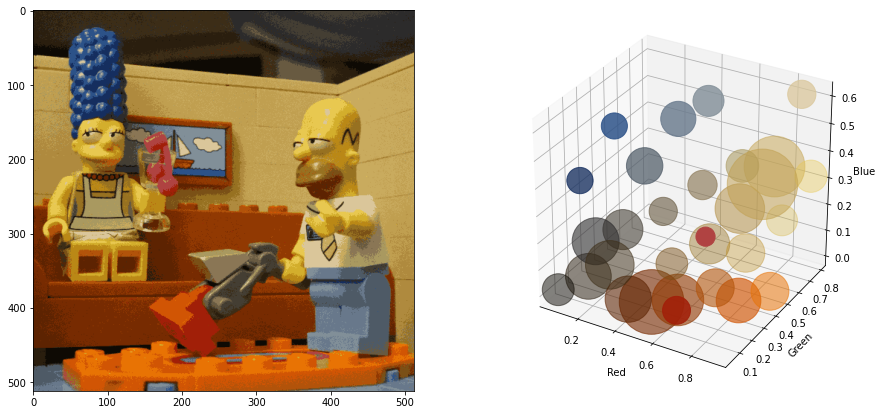

In [20]:
k=30
imnoise = imrgb + 5/255*np.random.randn(nrow,ncol,3)
todo_color_quantization_with_kmeans(imnoise,k)

## White Balance

### White point

Assume that a light source has a constant spectral density on the
range of wavelengths $[a,b]$, i.e 
$$ f(\lambda) = \frac{1}{b-a}\mathbf{1}_{[a,b]}(\lambda).$$
What is the spectral density of this light source expressed as a
function of frequency instead of wavelength ?
Recall that frequency and wavelength of a light source are related by
$\nu = \frac c \lambda$, with $c$ the light speed.
What can be deduced on the possible definition of a white light ?

***Answer:*** *there is no good definition of a white light. If a random variable $X$ follows a uniform distribution on $[a,b]$, then the random variable $\frac c{X} $ is such that  
$\mathbb{P}[\frac c{X}< \nu] = \mathbb{P}[X > c/\nu] = b-c/\nu$, so the probability distribution function of $\frac c{X}$ is the function $\nu \rightarrow c/{\nu}^2\mathbf{1}_{[c/b,c/a]}(\nu)$.*

### White balance algorithms

The chromaticities of objects in a scene
are highly dependent on the light sources. The goal of the white
balance algorithms is to estimate the color $e = (e_R,e_G,e_B)$ of the
illuminant and to globally correct the image using this estimate so
that it appears as if taken under a canonical illuminant, by
computing  
$$R= \frac{R}{e_R},\; G= \frac{G}{e_G}\; B=\frac{B}{e_B}.$$

In this exercice, we propose to code and test some famous white balance algorithms on the image 'moscou.bmp' below. The white balance of the image is clearly not correct (the walls should be white).

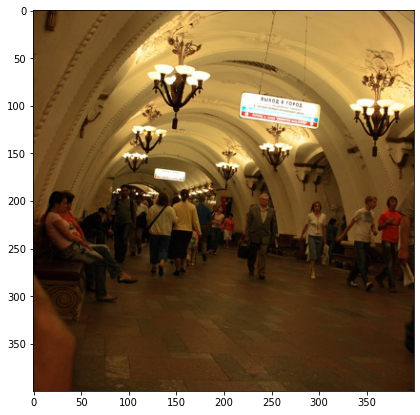

In [21]:
os.system("wget -c https://raw.githubusercontent.com/judelo/notebooks/master/im/moscou.bmp")
im_moscow = plt.imread("moscou.bmp")/255

plt.figure(figsize=(7, 7))
plt.imshow(im_moscow)

#### *White patch.*
The White-Patch assumption supposes that a surface with perfect
reflectance is present in the scene and that this surface correspond
to the brighter points in the image. This results in the well-known
Max-RGB algorithm, which infers the illuminant by computing separately
the maxima $(R_{max},G_{max},B_{max})$ of the three RGB channels :
    $$e_R= \frac{R_{max}}{255},\; e_G= \frac{G_{max}}{255}\; e_B=\frac{B_{max}}{255}.$$

In practice, relying only on the brightest pixel in the image might not be a good idea. For instance on the image above, this brightest pixel has the value (255,255,255) also the white balance of the image is clearly not correct. 

A more robust solution consists in choosing the mean value of small percentage of the brightest pixels for $e_R$, $e_G$ and $e_B$.


[0.91496901 0.79255944 0.53712305]


Text(0.5, 1.0, 'White-Patch correction')

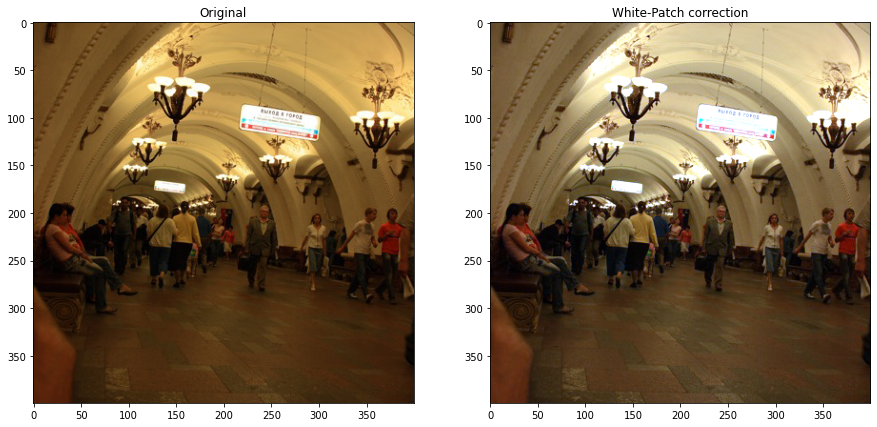

In [22]:
p = 0.1 # percentage of brightest pixels used for the white patch 
e = np.zeros((3,))
for k in range(3):
    imhisto,bins= np.histogram(im_moscow[:,:,k], range=(0,1), bins = 256) 
    imhisto     = imhisto/(im_moscow.shape[0]*im_moscow.shape[1])
    imhistocum = np.cumsum(imhisto)
    i=np.linspace(0,255,256)
    e[k] = np.sum(imhisto[imhistocum>1-p]*i[imhistocum>1-p])/np.sum(imhisto[imhistocum>1-p])/255
#e = e/np.mean(e)   # ensure that the image mean gray level won't change after multiplication by e 
print(e)

new = np.zeros(im_moscow.shape)
new[:,:,0] = im_moscow[:,:,0]/e[0]
new[:,:,1] = im_moscow[:,:,1]/e[1]
new[:,:,2] = im_moscow[:,:,2]/e[2]

fig, axe = plt.subplots(1,2,figsize=(15,15))
axe[0].imshow(im_moscow)
axe[0].set_title('Original')
axe[1].imshow(new)
axe[1].set_title('White-Patch correction')

#### *Grey world.*
A very popular way to estimate illuminant chromaticities in images is
to assume that under a canonic light, the average RGB value observed
in a scene is grey. This assumption gives rise to the Grey-World
algorithm, which consists in computing the average color in the image
and compensating for the deviation due to the illuminant, i.e. 
$$e_R = \frac{\int R(x)dx)}{128}, e_G = \frac{\int G(x) dx}{128}, e_B = 
\frac{\int B(x) dx}{128}.$$






[0.85092695 0.62052017 0.31658208]


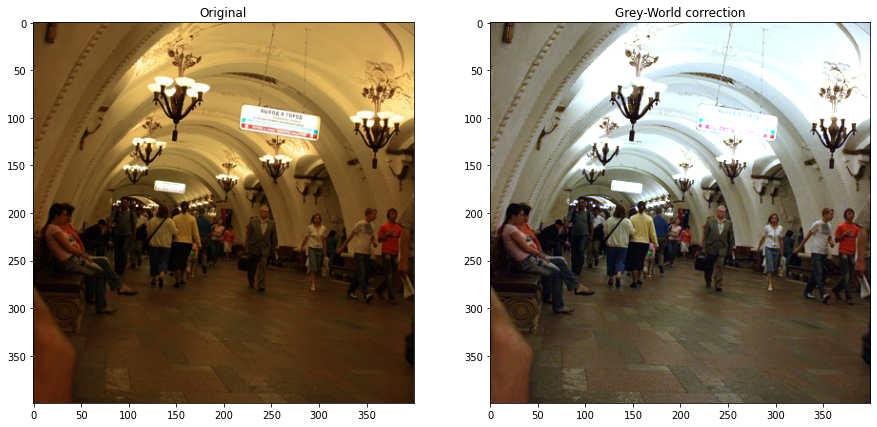

In [23]:
todo_gray_world(im_moscow)

#### *Shades-of-gray.* 
The Gray-World algorithm was generalized into the Shades-of-Gray algorithm by adding the Minkowski norm p: 
$$e_R = \left(\int R^p(x)dx\right)^{1/p}, e_G = \left(\int G^p(x)dx\right)^{1/p}, e_B =\left(\int B^p(x)dx\right)^{1/p}.$$

[126.38195332  99.17637474  59.83502063]


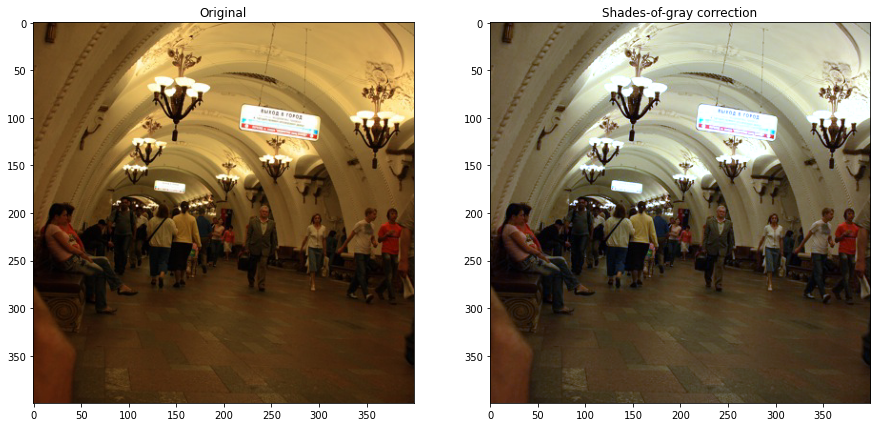

In [24]:
p=2
todo_shades_of_gray(im_moscow,p)

#### *General Gray-world*
The previous algorithm is extended by smoothing locally the three
channels by a Gaussian filter of standard deviation $\sigma$.

## Demosaicing
The following exercice can be done with the images `parrot` or `lighthouse`.
We will first create a RAW image from the RGB one: at each pixel, only one channel is kept
(red, green or blue), following the Bayer CFA. Remind that the bayer
CFA has the following structure :

      
      | R |   | G |   | R  |   | G ||
      |---+---+---+---+----+---+---||
      | G |   | B |   | G  |   | B ||
      |---+---+---+---+----+---+---||
      | R |   | G |   | R  |   | G ||
      |---+---+---+---+----+---+---||
      | G |   | B |   | G  |   | B ||
      
- Open the `parrot` or `lighthouse` image and create a RAW images using the previous Bayer filter. Display the resulting image. 



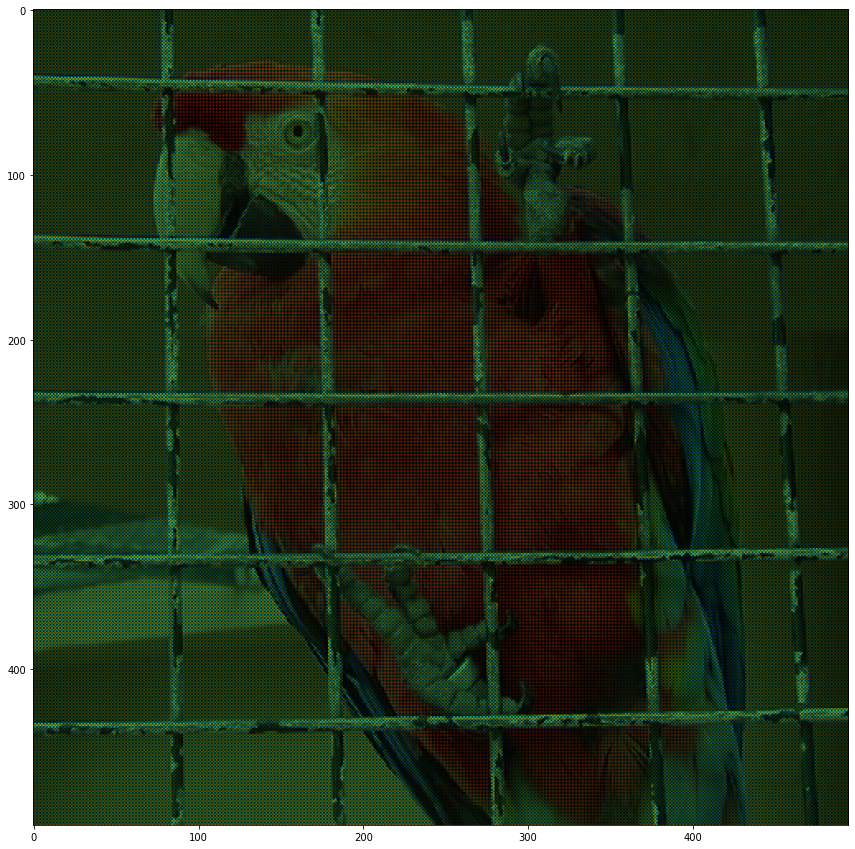

In [25]:
imrgb =plt.imread("parrot.png")
# extract the three (red,green,blue) channels from imrgb
imred   = imrgb[:,:,0]
imgreen = imrgb[:,:,1]
imblue  = imrgb[:,:,2]

#image size 
[nrow,ncol,nch]=imrgb.shape

raw = np.zeros(imrgb.shape, imrgb.dtype)
raw[0:nrow:2, 0:ncol:2, 1] = imgreen[0:nrow:2, 0:ncol:2]
raw[1:nrow:2, 1:ncol:2, 1] = imgreen[1:nrow:2, 1:ncol:2]
raw[0:nrow:2, 1:ncol:2, 0] = imred[0:nrow:2, 1:ncol:2]
raw[1:nrow:2, 0:ncol:2, 2] = imblue[1:nrow:2, 0:ncol:2]
plt.figure(figsize=(15, 15))
plt.imshow(raw)

Now, in order to retrieve the original image, we can try to
interpolate each channel, for instance by bilinear
interpolation. 

In [26]:
output = todo_interpolate_3_channels(raw,imrgb)

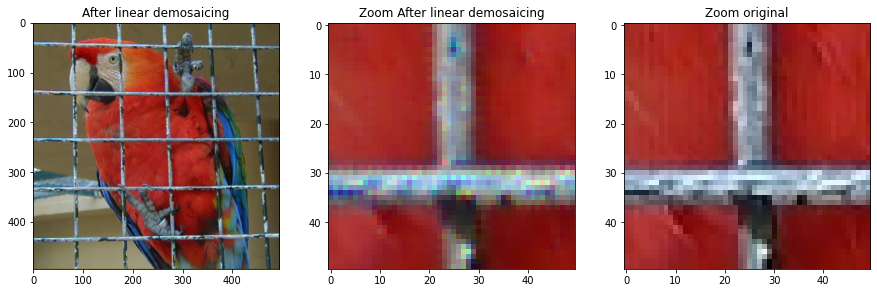

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].set_title('After linear demosaicing')
axes[0].imshow(output)
axes[1].set_title('Zoom After linear demosaicing')
axes[1].imshow(output[300:350,250:300])
axes[2].set_title('Zoom original')
axes[2].imshow(imrgb[300:350,250:300])

- Zoom on the metal grid and observe the mosaic artifacts. How can
     you explain them ? 
     
     
- In order to understand these artifacts, create
     a white image with a black square in the first top quarter and
     apply the same process (RAW image creation and demosaicing by
     bilinear interpolation of each channel). Comment the result.



Text(0.5, 1.0, 'Raw')

<Figure size 432x432 with 0 Axes>

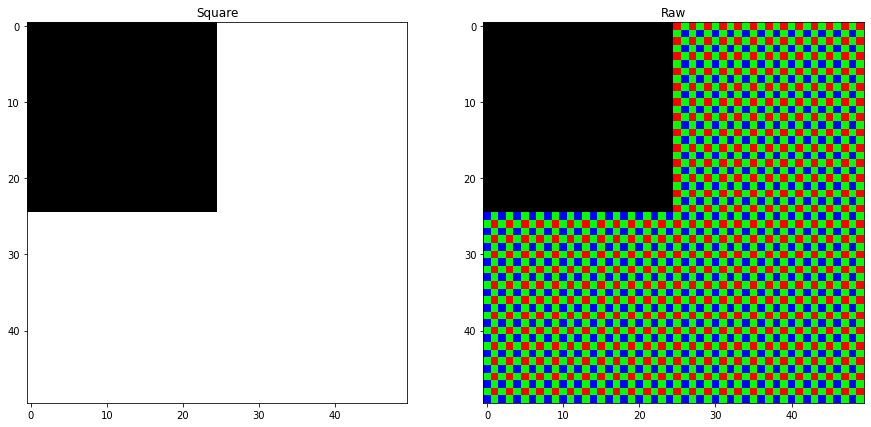

In [28]:
nrow = 50
ncol = 50
square = np.ones((nrow,ncol,3))*255
square[0:round(nrow/2), 0:round(ncol/2), :] = 0

raw = np.zeros(square.shape, square.dtype)
raw[0:nrow:2, 0:ncol:2, 1] = square[0:nrow:2, 0:ncol:2, 1]
raw[1:nrow:2, 1:ncol:2, 1] = square[1:nrow:2, 1:ncol:2, 1]
raw[0:nrow:2, 1:ncol:2, 0] = square[0:nrow:2, 1:ncol:2, 0]
raw[1:nrow:2, 0:ncol:2, 2] = square[1:nrow:2, 0:ncol:2, 2]
plt.figure(figsize=(6, 6))

fig, axe = plt.subplots(1,2,figsize=(15,15))
axe[0].imshow(square/255)
axe[0].set_title('Square')
axe[1].imshow(raw/255)
axe[1].set_title('Raw')

In [29]:
output = todo_interpolate_3_channels(raw,square)

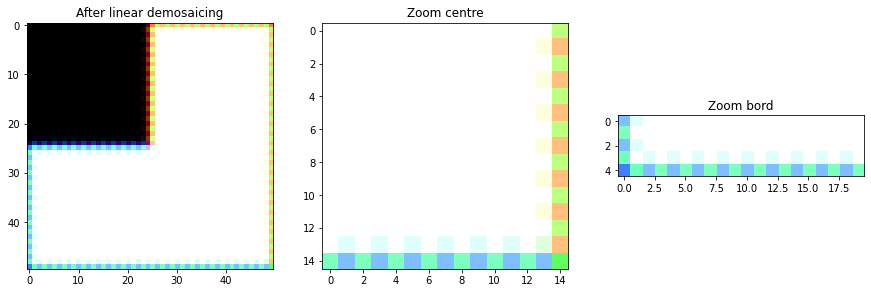

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].set_title('After linear demosaicing')
axes[0].imshow(output/255)
axes[1].set_title('Zoom centre')
axes[1].imshow(output[35:55,35:55]/255)
axes[2].set_title('Zoom bord')
axes[2].imshow(output[45:65,:20]/255)